## Download and check rdf2vec

In [1]:
import sys
sys.path.append('../code')

In [2]:
from settings import VECTOR_SIZE, CLASSIFIER_EPOCHS
TRAIN_RDF2VEC = False

# Load Dataset and Train rdf2vec

In [3]:
if TRAIN_RDF2VEC:
    import subprocess
    subprocess.run("python code/train_jrdf2vec.py".split())

## Parse Graph

In [4]:
from rdflib import Graph, URIRef
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx



g_train = Graph()
g_val = Graph()
g_test = Graph()

g_train = g_train.parse('FB15k-237/train.nt', format='nt')
g_val   = g_val.parse('FB15k-237/valid.nt', format='nt')
g_test  = g_test.parse('FB15k-237/test.nt', format='nt')


In [7]:
from gensim.models import Word2Vec


word_vectors = Word2Vec.load('walks/model').wv

In [8]:
from utils_graph import clean_graph,get_entities
# clean graphs 
# number of triples removed should be low, a few hundred
print(f"removed {clean_graph(g_train,word_vectors)} triples from training set")
print(f"removed {clean_graph(g_val,word_vectors)} triples from validation set")
print(f"removed {clean_graph(g_test,word_vectors)} triples from test set")

entities = get_entities((g_train,g_val,g_test))

removed 259 triples from training set
removed 37 triples from validation set
removed 59 triples from test set


In [9]:
from pathlib import Path
import pandas as pd
import torch
import torchmetrics
from models import ClassifierSimple
from utils_train import fit_1_1
model = ClassifierSimple()    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if Path('rdf2vecClassfier.pth').is_file():
    print('found trained model! Loading :)')
    model.load_state_dict(torch.load('rdf2vecClassfier.pth'))
    history = pd.read_csv('log.csv')
    model = model.to(device)
else:
    model = model.to(device)
    model,history = fit_1_1(model,g_train,lambda x: word_vectors[x],3000,entities,metrics = {'acc' :torchmetrics.classification.Accuracy()},graph_eval=g_val,epochs=5)
    model.eval()
    torch.save(model.state_dict(),'rdf2vecClassfier.pth')

2022-11-17 14:11:08.581143: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-17 14:11:08.581162: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:26<00:00, 29.38s/it]


<AxesSubplot:>

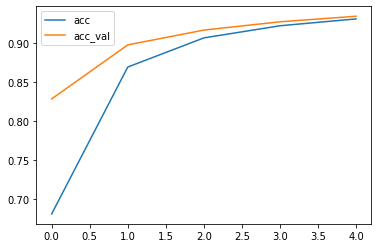

In [10]:
pd.DataFrame(history)[['acc','acc_val']].plot()

<AxesSubplot:>

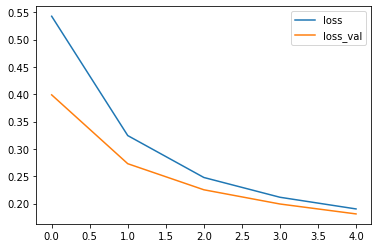

In [11]:
pd.DataFrame(history)[['loss','loss_val']].plot()